# Exercises - GEO4902-03 - Ensemble Prediction

Kjersti Stangeland, Fall 2024

# Exercise 03-01 - Ensemble prediction of a precipitation extreme event

The script gives you a framework to assess ensemble forecasts from the Scandinavian ensemble forecasting system. All 10 ensemble members are within one forecast file.

The extreme precipitation event (Telemark, Agder, Vestfold) occurred on 13th July 2019.

- You can decide on an initial time you want to use to assess the ensemble forecasts. In total, use two different initial times to get an idea of predictability for this event.

In [21]:
# import packages
import xarray as xr
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm
import cmocean.cm as cmo

#### Load ensemble forecast

In [41]:
year =  '2019'
day  =  '11'
month = '07'
hour_1  ='06'

url = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/'+year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

In [42]:
year =  '2019'
day  =  '13'
month = '07'
hour_1  ='06'

url = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/'+year+'/'+month+'/'+day+'/meps_subset_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_2 = xr.open_dataset(url)

In [43]:
# As we're only looking at precipitation in this exercise, to spare some memory, I will only keep the datavariable I need and drop all the other ones
fc_11 = forecast_1.precipitation_amount_acc
fc_13 = forecast_2.precipitation_amount_acc

- Plot the spatial maps of 6-hour accumulated precipitation for different ensemble members. Note the variable in the forecast file is accumulated precipitation from the start of the forecast, so you need to “de-accumulate” the fields. You will note differences between all the 10 ensemble members.

In [106]:
timestep = 12
fc_11_now = fc_11.isel(time=-7)
fc_11_6hr_ago = fc_11.isel(time=-7 - 6)
fc_11_6hracc = fc_11_now - fc_11_6hr_ago

In [109]:
fc_13_now = fc_13.isel(time=timestep)
fc_13_6hr_ago = fc_13.isel(time=timestep - 6)
fc_13_6hracc = fc_13_now - fc_13_6hr_ago

Text(0.5, 0.98, 'Forecasted 6hr accumulated precipitation 18 UTC 13th July 2019')

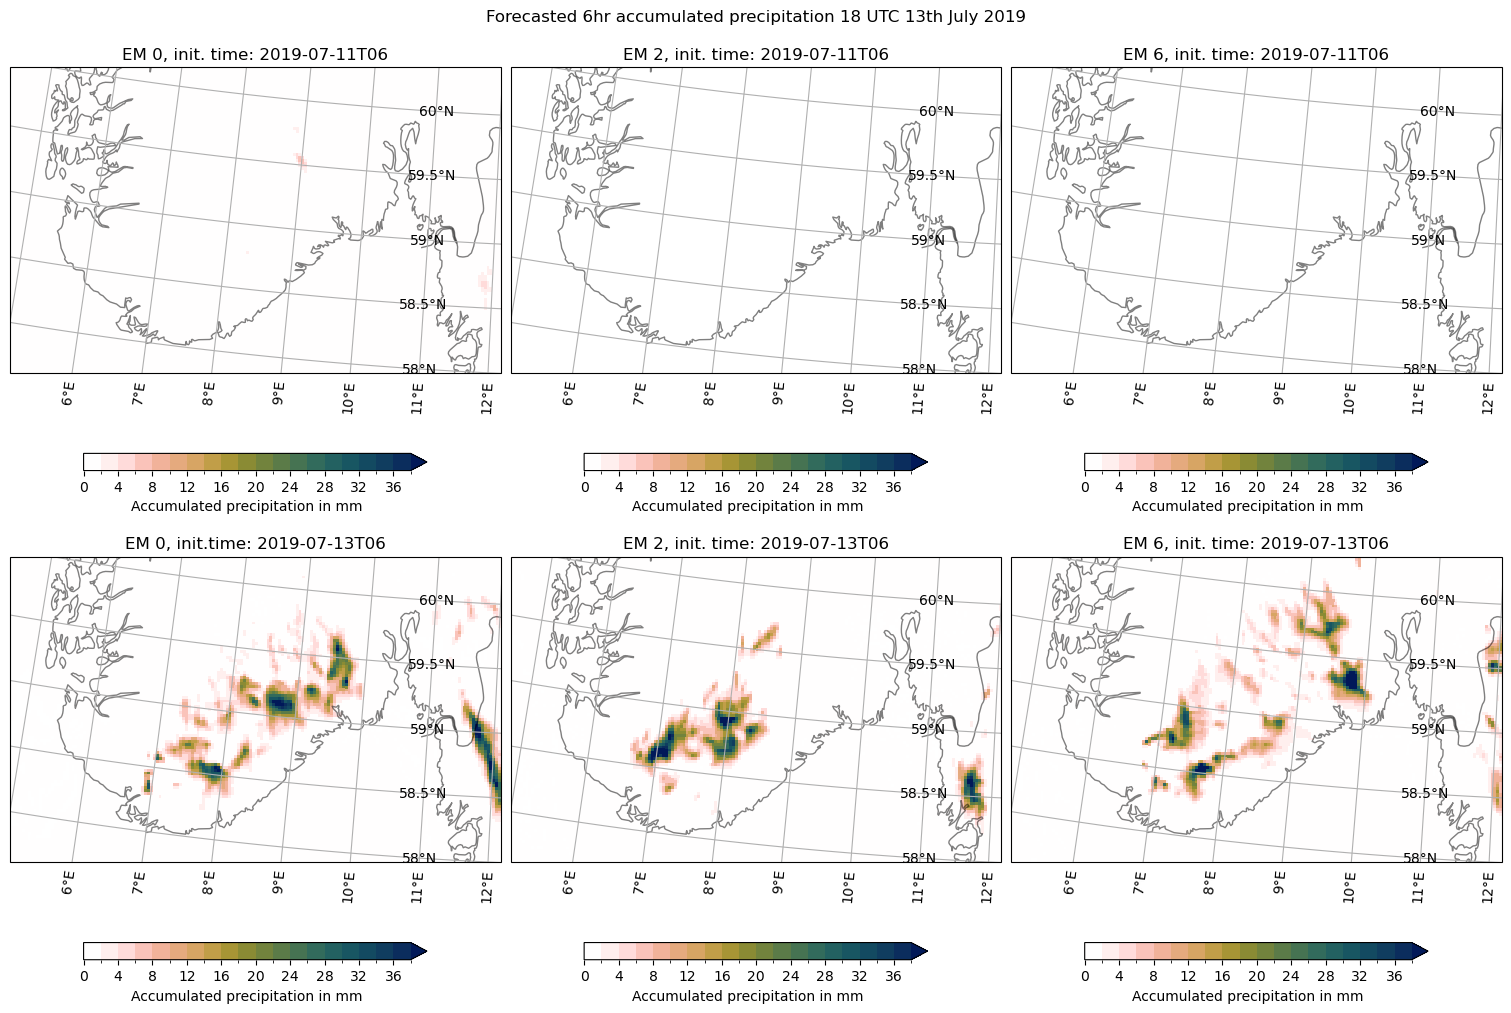

In [115]:
fig, ax = plt.subplots(2, 3, subplot_kw={'projection':projection}, figsize =(15,10), constrained_layout=True)

for axs in ax.flatten():
    axs.set_extent([5, 12, 58, 60], crs=cy.crs.PlateCarree())
    axs.add_feature(cy.feature.COASTLINE, alpha=0.5)
    axs.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = axs.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = True

forecast_time1 = np.datetime_as_string(forecast_1.time[0], unit='h')
forecast_time2 = np.datetime_as_string(forecast_2.time[0], unit='h')   

# ax[0, 0] : ensemble 0, fc 1
fc_11_6hracc.isel(ensemble_member = 0, height0=0).plot.pcolormesh(ax=ax[0,0], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[0,0].set_title(f'EM 0, init. time: {forecast_time1}')

# ax[0, 1] : ensemble 2, fc 1
fc_11_6hracc.isel(ensemble_member = 2, height0=0).plot.pcolormesh(ax=ax[0,1], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[0,1].set_title(f'EM 2, init. time: {forecast_time1}')

# ax[0, 2] : ensemble 6, fc 1
fc_11_6hracc.isel(ensemble_member = 6, height0=0).plot.pcolormesh(ax=ax[0,2], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[0,2].set_title(f'EM 6, init. time: {forecast_time1}')


# ax[1, 0] : ensemble 0, fc 2
fc_13_6hracc.isel(ensemble_member = 0, height0=0).plot.pcolormesh(ax=ax[1,0], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[1,0].set_title(f'EM 0, init.time: {forecast_time2}')

# ax[1, 1] : ensemble 1, fc 2
fc_13_6hracc.isel(ensemble_member = 2, height0=0).plot.pcolormesh(ax=ax[1,1], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[1,1].set_title(f'EM 2, init. time: {forecast_time2}')

# ax[1, 2] : ensemble 6, fc 2
fc_13_6hracc.isel(ensemble_member = 6, height0=0).plot.pcolormesh(ax=ax[1,2], x='longitude', y='latitude', cmap=cm.batlowW_r, extend='max',levels=np.arange(0,40,2), transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Accumulated precipitation in mm', 'shrink':0.7, 'pad':0.1})
ax[1,2].set_title(f'EM 6, init. time: {forecast_time2}')

fig.suptitle('Forecasted 6hr accumulated precipitation 18 UTC 13th July 2019')

__Comments on first task:__
- It is clear to see that the forecats initialized 11.07.19 did not see the large precipiation event on 13.07.19 coming. One of the members (EM 0) forecasted some precipition, while the others had nothing. 
- The forecast initialized 13.07.19 forecasted precipiation over the southern part of Norway. However the members did not agree on the severity of the precipitation amount or the location of it. 

- Do you have ideas on how to derive forecast products that combine the information of the 10 ensemble members but still give information about the severity (i.e., the extreme) of the forecasted weather situation?

- Plot your own ensemble forecast product (from part 3) or derive a forecast plot that shows the probability of 6 hourly precipitation which exceeds a certain threshold (e.g., 20 mm per 6 hours).